# Forward Collars
Price forward collars using different models.

In [ ]:
from datetime import datetime

import numpy as np
import pandas as pd
import pyarrow as pa
from matplotlib import pyplot as plt
from qablet.black_scholes.mc import LVMCModel
from qablet.heston.mc import HestonMCModel
from qablet_contracts.timetable import TS_EVENT_SCHEMA

from data.samples import heston_data, localvol_data, rbergomi_data
from src.model.rbergomi import rBergomiMCModel

### Forward Collars
Forward collars are not in the qablet_contracts package. We will write a method to create forward collars here, using the [qablet specifications](https://qablet.github.io/qablet-contracts/specifications/timetable/)

In [ ]:
# Create a Collar
def fwd_collar_timetable(ticker, strike_rate, width, strike_time, maturity):
    events = [
        {
            "track": None,
            "time": strike_time,
            "op": None,
            "quantity": 0,
            "unit": "FIX",  # set strike
        },
        {
            "track": "",
            "time": maturity,
            "op": "+",
            "quantity": 1,
            "unit": "COLLAR",  # pay collar
        },
    ]

    # Define the strike phrase, return the spot itself.
    def strike_fn(inputs):
        [s] = inputs
        return [s * strike_rate]

    # Define collar phrase.
    def collar_pay_fn(inputs):
        [s, k] = inputs

        ret = np.maximum(-width, s - k)
        ret = np.minimum(width, ret)

        return [ret]

    events_table = pa.RecordBatch.from_pylist(events, schema=TS_EVENT_SCHEMA)
    return {
        "events": events_table,
        "expressions": {
            "COLLAR": {
                "type": "phrase",
                "inp": [ticker, "K"],
                "fn": collar_pay_fn,
            },
            "FIX": {
                "type": "snapper",
                "inp": [ticker],
                "fn": strike_fn,
                "out": ["K"],
            },
        },
    }


# Try en example:
timetable = fwd_collar_timetable(
    "SPX", 1.0, 10, datetime(2013, 10, 31), datetime(2013, 12, 31)
)
print(timetable["events"].to_pandas())

  track                      time   op  quantity    unit
0   NaN 2013-10-31 00:00:00+00:00  NaN       0.0     FIX
1       2013-12-31 00:00:00+00:00    +       1.0  COLLAR


The Collar Payoff like this.

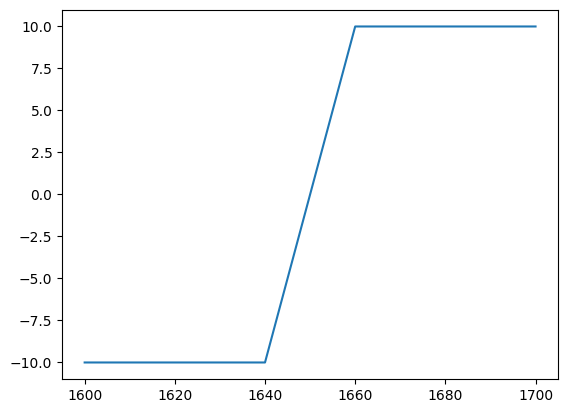

In [ ]:
K = 1650
s_vec = np.linspace(K - 50, K + 50, 11)
fn = timetable["expressions"]["COLLAR"]["fn"]
pay_vec = fn([s_vec, K])[0]
plt.plot(s_vec, pay_vec)

Create a series of forward collars starting at different expiration dates, setting strike one month prior.

In [ ]:
dates = pd.bdate_range(
    datetime(2013, 8, 30), datetime(2014, 8, 29), freq="2BME"
)
fix_dates = dates[:-1]
exp_dates = dates[1:]

timetables = []
for fix_dt, exp_dt in zip(fix_dates, exp_dates):
    timetables.append(
        fwd_collar_timetable(
            "SPX",
            strike_rate=1.0,
            width=10,
            strike_time=fix_dt,
            maturity=exp_dt,
        )
    )

### Compare Models
Compare different models, starting with Local Volatility Model.

In [ ]:
model = LVMCModel()

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, localvol_data())
    prices.append(price)

df = pd.DataFrame(
    {"fix date": fix_dates, "exp date": exp_dates, "LocalVol": prices}
)
df

,fix date,exp date,LocalVol
0,2013-08-30,2013-10-31,2.050608
1,2013-10-31,2013-12-31,1.467853
2,2013-12-31,2014-02-28,0.925652
3,2014-02-28,2014-04-30,0.657573
4,2014-04-30,2014-06-30,0.413980
5,2014-06-30,2014-08-29,0.192388


Heston Model

In [ ]:
model = HestonMCModel()

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, heston_data())
    prices.append(price)
df["Heston"] = prices
df

,fix date,exp date,LocalVol,Heston
0,2013-08-30,2013-10-31,2.050608,2.310629
1,2013-10-31,2013-12-31,1.467853,1.595248
2,2013-12-31,2014-02-28,0.925652,1.456470
3,2014-02-28,2014-04-30,0.657573,1.440869
4,2014-04-30,2014-06-30,0.413980,1.440134
5,2014-06-30,2014-08-29,0.192388,1.403311


Bergomi Model

In [ ]:
model = rBergomiMCModel()
dataset = rbergomi_data()
dataset["MC"]["PATHS"] = 10_000  # very slow with 100_000, 1/250
dataset["MC"]["TIMESTEP"] = 1 / 100

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, dataset)
    prices.append(price)
df["rBergomi"] = prices
df

,fix date,exp date,LocalVol,Heston,rBergomi
0,2013-08-30,2013-10-31,2.050608,2.310629,1.164407
1,2013-10-31,2013-12-31,1.467853,1.595248,1.120310
2,2013-12-31,2014-02-28,0.925652,1.456470,0.855147
3,2014-02-28,2014-04-30,0.657573,1.440869,0.921219
4,2014-04-30,2014-06-30,0.413980,1.440134,1.008746
5,2014-06-30,2014-08-29,0.192388,1.403311,0.813574


## Plot

<Axes: xlabel='exp date'>

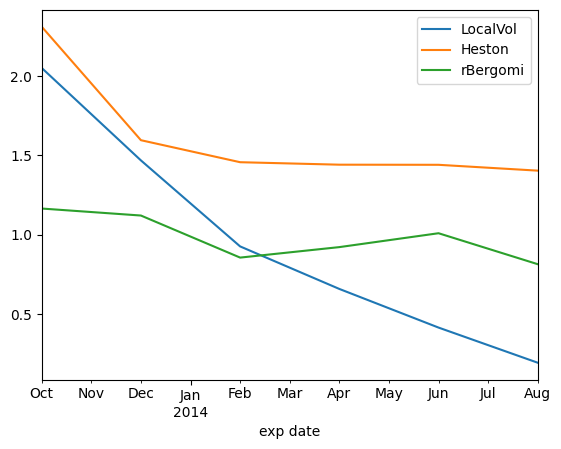

In [ ]:
df.columns
df.plot(x="exp date", y=["LocalVol", "Heston", "rBergomi"])